In [1]:
import numpy as np  
import random
import pdb
from sklearn.linear_model import LinearRegression  
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from numpy.linalg import inv

import warnings
warnings.filterwarnings("ignore")

# Optional: suppress secure RNG warning from Opacus
import logging
logging.getLogger("opacus").setLevel(logging.ERROR)

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import bisect

def mu_to_epsilon(mu):
    """
    Compute the epsilon corresponding to a given mu under Gaussian Differential Privacy (GDP).
    
    Parameters:
    mu (float): The mu parameter in GDP.
    
    Returns:
    float: The corresponding epsilon value.
    """
    # Define the function whose root we want to find
    def func(epsilon):
        return mu + 2 * norm.ppf(1 / (1 + np.exp(epsilon)))
    
    # Use bisection method to find the root
    # Set reasonable bounds for epsilon
    epsilon_lower = 0.0
    epsilon_upper = 100.0  # Adjust as needed for higher mu values
    
    # Ensure that the function changes sign over the interval
    if func(epsilon_lower) * func(epsilon_upper) >= 0:
        raise ValueError("Bisection method fails: f(epsilon_lower) and f(epsilon_upper) must have opposite signs.")
    
    # Find the root
    epsilon = bisect(func, epsilon_lower, epsilon_upper, xtol=1e-10)
    return epsilon


In [3]:
import numpy as np

def privtree_binning_XY_with_theta(X, Y, x_lb, x_ub, mu, theta, branching_factor=2):
    """
    PrivTree Binning for (X,Y) with hyperparameter (theta, sigma, gamma) as Inputs
    """
    # Configuration
    beta = branching_factor
    epsilon = mu_to_epsilon(mu)
    # print(mu, epsilon)
    lambda_ = (2 * beta - 1) / (beta - 1) / epsilon
    delta = lambda_ * np.log(beta)

    n_samples, n_features = X.shape
    # Add 1e-8 to upper bounds to ensure inclusivity
    initial_bins = [(x_lb, x_ub + 1e-8) for i in range(n_features)]
    bins = [initial_bins]
    depths = [0]

    x_bins_list, sum_x, sum_y, counts = [], [], [], []
    bin_counter = 0

    assigned_mask = np.zeros(n_samples, dtype=bool)  # For debugging completeness

    while bins:
        current_bins = bins.pop(0)
        current_depth = depths.pop(0)

        # Use inclusive upper bound to avoid dropping points on the edge
        bin_mask = np.all([
            (X[:, i] >= current_bins[i][0]) & (X[:, i] <= current_bins[i][1])
            for i in range(n_features)
        ], axis=0)

        X_bin, Y_bin = X[bin_mask], Y[bin_mask]
        N_bin = len(X_bin)

        # if N_bin > 0:
        S_Y_bin = np.sum(Y_bin)
        S_X_bin = np.sum(X_bin, axis=0)

        raw_score = N_bin - delta * current_depth
        biased_score = max(raw_score, theta - delta)
        noisy_score = biased_score + np.random.laplace(scale=lambda_)
        # print("delta",delta, "current_depth", current_depth, "N_bin", N_bin, \
              # "raw_score", raw_score, "biased_score",biased_score,"noisy_score",noisy_score)

        if noisy_score > theta:
            # print("split")
            # Find the dimension with the largest width
            widths = [right - left for (left, right) in current_bins]
            i = np.argmax(widths)
            midpoint = (current_bins[i][0] + current_bins[i][1]) / 2
            left_bin, right_bin = list(current_bins), list(current_bins)
            left_bin[i] = (current_bins[i][0], midpoint)
            right_bin[i] = (midpoint, current_bins[i][1])
            bins += [left_bin, right_bin]
            depths += [current_depth + 1, current_depth + 1]
        
        else:
            # print("NOT split OUTPUT")
            counts.append(N_bin)
            x_bins_list.append(current_bins)
            bin_counter += 1
            sum_x.append(S_X_bin)
            sum_y.append(S_Y_bin)
            assigned_mask[bin_mask] = True

  # Post-processing: Ensure at least n_features + 1 bins
    min_total_bins = n_features + 1
    if len(x_bins_list) == 0:
        # Initialize with the entire feature space as one bin
        bin_mask = np.all([
            (X[:, i] >= initial_bins[i][0]) & (X[:, i] <= initial_bins[i][1])
            for i in range(n_features)
        ], axis=0)
        X_bin = X[bin_mask]
        Y_bin = Y[bin_mask]
        N_bin = len(X_bin)
        S_X_bin = np.sum(X_bin, axis=0)
        S_Y_bin = np.sum(Y_bin)
        x_bins_list = [initial_bins]
        sum_x = [S_X_bin]
        sum_y = [S_Y_bin]
        counts = [N_bin]

    while len(x_bins_list) < min_total_bins:
        volumes = [
            np.prod([right - left for (left, right) in bin_bounds])
            for bin_bounds in x_bins_list
        ]
        max_idx = np.argmax(volumes)
        current_bin = x_bins_list[max_idx]

        widths = [right - left for (left, right) in current_bin]
        max_width = max(widths)
        max_dims = [i for i, w in enumerate(widths) if w == max_width]
        split_dim = random.choice(max_dims)
        left_edge, right_edge = current_bin[split_dim]
        midpoint = (left_edge + right_edge) / 2

        left_bin = list(current_bin)
        right_bin = list(current_bin)
        left_bin[split_dim] = (left_edge, midpoint)
        right_bin[split_dim] = (midpoint, right_edge)

        bin_mask = np.all([
            (X[:, i] >= current_bin[i][0]) & (X[:, i] <= current_bin[i][1])
            for i in range(n_features)
        ], axis=0)
        X_bin = X[bin_mask]
        Y_bin = Y[bin_mask]

        left_mask = (X_bin[:, split_dim] < midpoint)
        right_mask = ~left_mask

        X_left, Y_left = X_bin[left_mask], Y_bin[left_mask]
        X_right, Y_right = X_bin[right_mask], Y_bin[right_mask]

        count_left = len(X_left)
        count_right = len(X_right)

        sum_x_left = np.sum(X_left, axis=0) if count_left > 0 else np.zeros(n_features)
        sum_y_left = np.sum(Y_left) if count_left > 0 else 0.0

        sum_x_right = np.sum(X_right, axis=0) if count_right > 0 else np.zeros(n_features)
        sum_y_right = np.sum(Y_right) if count_right > 0 else 0.0

        x_bins_list.pop(max_idx)
        sum_x.pop(max_idx)
        sum_y.pop(max_idx)
        counts.pop(max_idx)

        x_bins_list.append(left_bin)
        sum_x.append(sum_x_left)
        sum_y.append(sum_y_left)
        counts.append(count_left)

        x_bins_list.append(right_bin)
        sum_x.append(sum_x_right)
        sum_y.append(sum_y_right)
        counts.append(count_right)

    return (
        x_bins_list,
        np.array(sum_x),
        np.array(sum_y),
        np.array(counts),
        bin_counter
    )


In [4]:
# DP-BinAgg: Add noise to sum_x, sum_y, counts         #
##########################################################################

def DP_fy_sum_x_y_counts(sum_x, sum_y, counts, x_bins_list, sens_y, priv_budget):
    epsilon_count = priv_budget / np.sqrt(3)
    epsilon_x = priv_budget / np.sqrt(3)
    epsilon_y = priv_budget / np.sqrt(3)
    # print(sum_x.shape[0])
    
    try: 
        K, d = sum_x.shape
    except ValueError:
        K = 1
    
    # Add noise to counts
    noisy_counts = np.rint(counts + np.random.normal(0, 1, size=K) / epsilon_count).astype(int) ## make noisy counts integers 
    # noisy_counts = counts + np.random.normal(0, 1, size=K) / epsilon_count ## or do not make noisy counts integers 

    # Compute sensitivity per x-dimension from bin bounds
    x_bins_list = np.array(x_bins_list)
    sens_x = np.maximum(np.abs(x_bins_list[..., 0]), np.abs(x_bins_list[..., 1]))
    
    # Add noise to sum_x with per-dimension sensitivity
    noisy_sum_x = sum_x + np.random.normal(0, sens_x, size=sum_x.shape) / epsilon_x
    
    # Add noise to sum_y
    noisy_sum_y = sum_y + np.random.normal(0, sens_y, size=K) / epsilon_y
    
    keep_mask = (noisy_counts > 1)
    noisy_counts = noisy_counts[keep_mask]
    counts_censored = counts[keep_mask]
    noisy_sum_x = noisy_sum_x[keep_mask]
    noisy_sum_y = noisy_sum_y[keep_mask]
    x_bins_list = x_bins_list[keep_mask]
    sens_x = np.maximum(np.abs(x_bins_list[..., 0]), np.abs(x_bins_list[..., 1]))
    
    return np.maximum(1, noisy_counts), counts_censored, noisy_sum_x, noisy_sum_y, sens_x, epsilon_count, epsilon_x, epsilon_y


In [5]:
##########################################################################
# DP-BinAgg: bias-correction matrix D    #
##########################################################################

def models_estimation_se(X, Y, x_lb, x_ub, sens_y, priv_budget_bin, priv_budget, theta):

    n, d = X.shape    
    ## DP-BinAgg: prep
    # x_bins_list, sum_x, sum_y, counts, _ = privtree_binning_XY_with_budget(X, Y, x_lb, x_ub, priv_budget_bin)
    #### ------ Use Noisy Sums directly: the same ------ 
    x_bins_list, sum_x, sum_y, counts, _ = privtree_binning_XY_with_theta(X, Y, x_lb, x_ub, priv_budget_bin, theta)
    noisy_counts, counts_censored, noisy_sum_x, noisy_sum_y, sens_x, epsilon_count, epsilon_x, epsilon_y \
    = DP_fy_sum_x_y_counts(sum_x, sum_y, counts, x_bins_list, sens_y, priv_budget)
    
    #### ------ Use Syn data and WLS: the same ------ 
    # _,_, noisy_sum_x, noisy_sum_y, noisy_counts,counts_censored, sens_x, epsilon_x\
    # = DP_fy_sum_x_y_counts_syn_data(sum_x, sum_y, counts, x_bins_list, sens_y, priv_budget)
    
    
    K, d = sens_x.shape
    D = np.zeros((d, d))
    D_k_list = []
    for k in range(K):
        # print(sens_x[k], sens_x[k]**2)
        D_k = np.diag(sens_x[k]**2 / epsilon_x**2)
        D_k_list.append(D_k)
        D += 1/noisy_counts[k] * D_k
    D /= K
    # print("D1", D)
    
    # ## DP-BinAgg: no privacy
    # S = sum_x
    # t = sum_y
    # W = np.diag(1 / np.maximum(1, counts))
    # beta_WLS = np.linalg.inv(S.T @ W @ S) @ (S.T @ W @ t)


    ## DP-BinAgg: Estimate beta
    # print(noisy_sum_x)
    tilde_S = noisy_sum_x
    tilde_t = noisy_sum_y
    tilde_W = np.diag(1 / noisy_counts)
    beta_DP_WLS = np.linalg.inv(tilde_S.T @ tilde_W @ tilde_S - D) @ (tilde_S.T @ tilde_W @ tilde_t)
    beta_naive = np.linalg.inv(tilde_S.T @ tilde_W @ tilde_S) @ (tilde_S.T @ tilde_W @ tilde_t)
    # print(beta_DP_WLS)
    ######### Naive Cov ################
    # Sigma_naive = sigma_lr * np.linalg.inv(tilde_S.T @ tilde_W @ tilde_S)
    try:
        Sigma_naive = sigma_lr * np.linalg.inv(tilde_S.T @ tilde_W @ tilde_S)
        se_naive = np.sqrt(np.diag(Sigma_naive))  
    except np.linalg.LinAlgError:
        se_naive = np.nan
                                  

    ################ COV ################
    tilde_S = np.vstack(tilde_S)
    tilde_t = np.array(tilde_t).flatten()
    tilde_W_vec = np.diag(tilde_W)
    # [print("w", w) for w, D_k in zip(np.diag(tilde_W), D_k_list)]
    # D = sum(w * D_k for w, D_k in zip(tilde_W_vec, D_k_list)) / K

    # print("D2", D)
    
    Q_QT_list = []
    # Compute residuals and Q_k
    for k in range(K):
        s_k = tilde_S[k, :]
        w_k = tilde_W[k, k]
        t_k = tilde_t[k]
        D_k = D_k_list[k]
        Q_k = s_k * w_k * (t_k - s_k @ beta_DP_WLS) + w_k * (D_k @ beta_DP_WLS)
        Q_QT_list.append(Q_k.reshape(-1, 1) @ Q_k.reshape(1, -1))

    
    M_tilde = (tilde_S.T @ tilde_W @ tilde_S) / K - D
    H_tilde = sum(Q_QT_list) / (K * (K - d))
    Sigma_tilde = inv(M_tilde) @ H_tilde @ inv(M_tilde)
    # print("inv(M_tilde)", inv(M_tilde), "H", H_tilde, "Q_QT_list", Q_QT_list, "(K * (K - d))", (K * (K - d)), "Sigma_tilde", Sigma_tilde)
    se = np.sqrt(np.diag(Sigma_tilde))

    # print(len(noisy_counts), len(counts_censored))
    return beta_DP_WLS, beta_naive, se, se_naive, K, counts, counts_censored, noisy_counts

In [6]:
# Clear variables, but keep functions, modules, and special names
import types

globals_to_keep = [name for name, obj in globals().items()
                   if callable(obj) or isinstance(obj, types.ModuleType) or name.startswith('__')]

for name in list(globals()):
    if name not in globals_to_keep:
        del globals()[name]


### CI

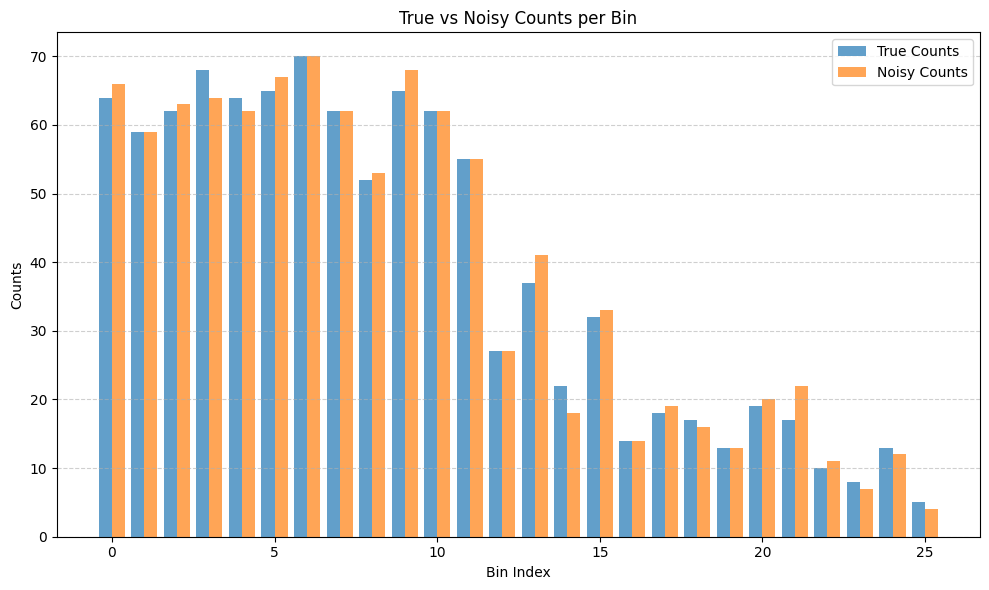

   Mean_Bias  Empirical_SE  Avg_Theoretical_SE  Naive Avg_Theoretical_SE  \
0  -0.009627      0.264480            0.270207                  0.112154   
1  -0.005836      0.276048            0.284932                  0.116106   
2   0.001476      0.282941            0.289448                  0.118255   
3  -0.000409      0.315347            0.329567                  0.127754   
4  -0.009462      0.541341            0.569824                  0.191036   

   Coverage  Naive Coverage  
0    0.9565          0.6205  
1    0.9500          0.6345  
2    0.9555          0.6240  
3    0.9510          0.6140  
4    0.9620          0.5485  


In [7]:
import numpy as np
import pandas as pd
from scipy.stats import norm, t
from numpy.linalg import inv

# Simulation settings
n_simulations = 2000
n_features = 5
sigma_lr = 1
n_samples =1000
alpha = 0.05 
theta = 0

## Budget setup 
mu = 1 ## total budget for GDP 
## split budget for binning and regression 1:9 ratio
priv_budget_bin = mu/np.sqrt(82)
priv_budget = mu*9/np.sqrt(82)


#
estimates = []
coverages = []
estimated_se = []

coverages_naive = []
estimated_se_naive = []


np.random.seed(42)
## Data setting
x_min, x_max = 0, 1
x_lb, x_ub = x_min, x_max
beta_lb, beta_ub = 1, 2
## Data bounds and sensitivities
X_norm_bound = max(np.abs(x_lb), np.abs(x_ub))*np.sqrt(n_features)

if n_features == 1:
    y_lb, y_ub = 0, 2
elif n_features ==5:
    y_lb, y_ub = 0, 7
elif n_features ==10:
    y_lb, y_ub = 0, 15
elif n_features ==20:
    y_lb, y_ub = 0, 15
elif n_features ==50:
    y_lb, y_ub = 0, 30
else:
    print("Please specify bounds for y")
    
Y_norm_bound = max(np.abs(y_lb), np.abs(y_ub))
sens_y = Y_norm_bound
XY_norm_bound = np.sqrt(X_norm_bound**2+Y_norm_bound**2)

X = np.random.uniform(x_lb, x_ub, size = (n_samples, n_features))
X_clipped = np.clip(X, x_lb, x_ub)
true_coeffs = np.random.uniform(beta_lb, beta_ub, size=n_features)

K_list = []
counts_censored_list = []
noisy_counts_list = []
for sim in range(n_simulations):
    # rng = np.random.default_rng(seed=sim)
    Y_original = X @ true_coeffs + np.random.normal(0, sigma_lr, size=n_samples)
    Y = np.clip(Y_original, y_lb, y_ub) ## clipping
    beta_DP_WLS,_, se, se_naive, K, counts, counts_censored, noisy_counts\
    = models_estimation_se(X, Y,  x_lb, x_ub, sens_y, priv_budget_bin, priv_budget, theta)

    ## store the #bins and counts info
    K_list.append(K)
    counts_censored_list.append(counts_censored)
    noisy_counts_list.append(noisy_counts)

    ## print a few plots of counts
    if sim%2000==0:
        assert len(counts_censored) == len(noisy_counts), "Mismatched array lengths!"
        bins_index = np.array(range(len(noisy_counts)))
        bar_width = 0.4
        plt.figure(figsize=(10, 6))
        plt.bar(bins_index - bar_width/2, counts_censored, width=bar_width, label="True Counts", alpha=0.7)
        plt.bar(bins_index + bar_width/2, noisy_counts, width=bar_width, label="Noisy Counts", alpha=0.7)
        plt.xlabel("Bin Index")
        plt.ylabel("Counts")
        plt.title("True vs Noisy Counts per Bin")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        
    
    # Confidence intervals and coverage
    
    t_alpha = t.ppf(1 - alpha / 2, K)
    lower = beta_DP_WLS - t_alpha * se
    upper = beta_DP_WLS + t_alpha * se
    cover = (true_coeffs >= lower) & (true_coeffs <= upper)

    estimates.append(beta_DP_WLS)
    estimated_se.append(se)
    coverages.append(cover)

    lower_naive = beta_DP_WLS - t_alpha * se_naive
    upper_naive = beta_DP_WLS + t_alpha * se_naive
    cover_naive = (true_coeffs >= lower_naive) & (true_coeffs <= upper_naive)
    
    estimates.append(beta_DP_WLS)
    estimated_se_naive.append(se_naive)
    coverages_naive.append(cover_naive)


# Convert results to DataFrame
estimates = np.array(estimates)
estimated_se = np.array(estimated_se)
coverages = np.array(coverages)

results = pd.DataFrame({
    "Mean_Bias": np.mean(estimates-true_coeffs, axis=0),
    "Empirical_SE": np.std(estimates, axis=0),
    "Avg_Theoretical_SE": np.mean(estimated_se, axis=0),
    "Naive Avg_Theoretical_SE": np.mean(estimated_se_naive, axis=0),
    "Coverage": np.mean(coverages, axis=0),
    "Naive Coverage": np.mean(coverages_naive, axis=0)
})

print(results)


In [8]:
def summarize_and_aggregate(list_of_lists):
    stats = {
        'min': [],
        'max': [],
        'mean': [],
        'median': [],
        'std': []
    }

    for data in list_of_lists:
        data = np.array(data)
        stats['min'].append(np.min(data))
        stats['max'].append(np.max(data))
        stats['mean'].append(np.mean(data))
        stats['median'].append(np.median(data))
        stats['std'].append(np.std(data, ddof=1))  # sample std

    # Compute mean and std for each statistic across the lists
    summary = {}
    for stat_name, values in stats.items():
        summary[stat_name] = {
            'mean': np.mean(values),
            'std': np.std(values, ddof=1)
        }

    return summary


def summarize_list(data):
    data = np.array(data)
    summary = {
        'min': np.min(data),
        'max': np.max(data),
        'mean': np.mean(data),
        'median': np.median(data),
        'std': np.std(data, ddof=1),  # sample std
        '25%': np.percentile(data, 25),
        '75%': np.percentile(data, 75)
    }
    return summary

In [9]:
print("bin number summary:", summarize_list(K_list))

summary_stats = summarize_and_aggregate(counts_censored_list)
print("true counts summary:")
for stat, vals in summary_stats.items():
   
    print(f"{stat}: mean = {vals['mean']:.2f}, std = {vals['std']:.2f}")

summary_stats = summarize_and_aggregate(noisy_counts_list)
print("noisy counts summary:")
for stat, vals in summary_stats.items():
    
    print(f"{stat}: mean = {vals['mean']:.2f}, std = {vals['std']:.2f}")


bin number summary: {'min': 12, 'max': 43, 'mean': 21.933, 'median': 21.0, 'std': 4.30950077137123, '25%': 19.0, '75%': 24.0}
true counts summary:
min: mean = 11.26, std = 10.52
max: mean = 102.22, std = 28.37
mean: mean = 47.28, std = 9.08
median: mean = 48.35, std = 13.04
std: mean = 25.14, std = 5.95
noisy counts summary:
min: mean = 11.21, std = 10.31
max: mean = 102.36, std = 28.29
mean: mean = 47.30, std = 9.04
median: mean = 48.26, std = 12.88
std: mean = 25.16, std = 5.94
